In [95]:
from clutter_filter import GroundClutterFilter
import numpy as np
import glob, os
# import radarkit
import radarkitIQ as radarkit
import momentgen as mg

In [96]:
# fname = '../data/20240524/RAXPOL-20240524-002125.654.rkc'
# fname = '../data/20240524/RAXPOL-20240524-002604.135.rkc'
# fname = '../data/20240524/RAXPOL-20240524-002543.944.rkc'
# fname = '../data/20250518/RAXPOL-20250518-225404.925.rkc'
# fname = '../data/20250605/D2/RAXPOL-20250605-223837.894.rkc'
# fname = '../data/20250518/RAXPOL-20250518-230109.539.rkc'
# fname = '../data/20250518/RAXPOL-20250518-230114.467.rkc'
# fname = '../data/20250605/D1/RAXPOL-20250605-215634.580.rkc'
fname = '../data/20250605/D2/RAXPOL-20250605-223837.894.rkc'
# rkid = radarkit.open(fname)
# out = rkid.read()
rkid = radarkit.rkcfile(fname)
print(rkid.pulses)

Filename: ../data/20250605/D2/RAXPOL-20250605-223837.894.rkc
preface = RadarKit/IQ   buildNo = 8
Pulse data size: 1613842912
gateCount = 12459   capacity = 36480   downSampledGateCount = 1246
data offset = 4792
Reading pulses ...
Number of pulses: 80179
[(142026, 146646, 35506500, 3311, 36480, 12459, 1246, 10, 35, 1749163117, 894268, 81517.88955682, [ 8, 41,  0,  0], [  2,  18,   0,   0], 7, 0, 120, 3., 2.9114172, 120.08498, -0.01647972, 18.204624, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [[[ 1.02457793e+04,  7.67295020e+03], [ 8.12072876e+02,  9.62597290e+02], [-2.15034542e+01, -1.29020905e+02], ..., [-2.52984190e+00, -5.69207525e+00], [-3.79470825e+00,  1.26492870e+00], [-6.32405043e-01, -1.26490474e+00]], [[ 3.27295728e+03, -2.48807983e+03], [-1.22316895e+03,  6.62180908e+0

In [97]:
# ciq = out['ciq']

# pulses_new = []
# print(np.array(pulses[0]['iq'][0]))
# for pulse in pulses:
	# pulses_new.append(pulse['iq'])
# pulses = np.array(pulses_new)

pulses = rkid.pulses['iq']
# (pulse, iq, gate, hv)
pulses = pulses.transpose((1,2,3,0))
# (iq, gate, hv, pulse)
pulses = pulses[0,:,:,:] + 1.j*pulses[1,:,:,:]
# (gate, hv, pulse)
pulses = pulses.transpose((0,2,1)).astype(np.complex128)
# (gate, pulse, hv)

# ciq = pulses

# lamb = rkid.desc.wavelength
# prt = radarkit.read_RKFloat_array(rkid.configs.contents.prt,1)
lamb = rkid.header['desc']['wavelength']
prt = rkid.header['config']['prt']
c = 299,792,458
sample_freq = int(rkid.header['waveform']['fs'])
sample_time = 1/sample_freq
va = lamb/(4*prt)
# C = np.abs(radarkit.read_RKComplex_array(rkid.configs.contents.systemZCal, 1)[0])
# l = np.abs(radarkit.read_RKComplex_array(rkid.configs.contents.systemZCal, 2)[1])

totaln = pulses.shape[1]
count = 50 # Pulses per ray
rayCount = int(np.floor(totaln/count)) # Rays per sweep
gateCount = pulses.shape[0]
n = rayCount * count

az = rkid.pulses['azimuthDegrees']
el = rkid.pulses['elevationDegrees']

# # he's expecting ciq to be in (pulse, h/v, range)
# X_h = np.reshape(ciq[:n, 0, :], (rayCount, count, -1))
# # transpose (ray, pulse, range(?)) to (range, ray, pulse)
# X_h = np.transpose(X_h, (2, 0, 1))

# X_v = np.reshape(ciq[:n, 1, :], (rayCount, count, -1))
# X_v = np.transpose(X_v, (2, 0, 1))

X_h = pulses[:,:n,0]
# (gate, pulse)
X_h = np.reshape(X_h, (gateCount, rayCount, count))
# (gate, ray, pulse)

X_v = pulses[:,:n,1]
X_v = np.reshape(X_v, (gateCount, rayCount, count))

az = np.reshape(az[:n], (rayCount, count))
az = az[:,0]
el = np.reshape(el[:n], (rayCount, count))
el = np.nanmean(el, axis=1)


In [98]:
"""# set some imporatnt radar parameter
wavelength_scalar = lamb
# prt_scalar = prt[0]
num_samples_actual = X_h.shape[2]

#filter the I/Q time series for the horizontal and vertical polarizations
filter_inst = GroundClutterFilter(
	wavelength=lamb,
	scan_rate=1/(count * prt),
	prt=prt,
	num_samples=count
)

print("\n--- Filtering X_h (Horizontal Polarization) ---")
filtered_i_h, filtered_q_h, poly_order_map_h, clutter_i_trend_map_h, clutter_q_trend_map_h, interpolated_spectrum_map_h = \
	filter_inst.filter_iq_data(X_h.real, X_h.imag, cnr_db_map=None, apply_interpolation=True)

filtered_X_h_optimized = filtered_i_h + 1j * filtered_q_h

del filtered_i_h, filtered_q_h, poly_order_map_h, clutter_i_trend_map_h, clutter_q_trend_map_h, interpolated_spectrum_map_h

print("\n--- Filtering X_v (Vertical Polarization) ---")
filtered_i_v, filtered_q_v, poly_order_map_v, clutter_i_trend_map_v, clutter_q_trend_map_v, interpolated_spectrum_map_v = \
	filter_inst.filter_iq_data(X_v.real, X_v.imag, cnr_db_map=None, apply_interpolation=True)

filtered_X_v_optimized = filtered_i_v + 1j * filtered_q_v

del filtered_i_v, filtered_q_v, poly_order_map_v, clutter_i_trend_map_v, clutter_q_trend_map_v, interpolated_spectrum_map_v

print("\nOptimization complete. Filtered data is in filtered_X_h_optimized and filtered_X_v_optimized.")"""

'# set some imporatnt radar parameter\nwavelength_scalar = lamb\n# prt_scalar = prt[0]\nnum_samples_actual = X_h.shape[2]\n\n#filter the I/Q time series for the horizontal and vertical polarizations\nfilter_inst = GroundClutterFilter(\n\twavelength=lamb,\n\tscan_rate=1/(count * prt),\n\tprt=prt,\n\tnum_samples=count\n)\n\nprint("\n--- Filtering X_h (Horizontal Polarization) ---")\nfiltered_i_h, filtered_q_h, poly_order_map_h, clutter_i_trend_map_h, clutter_q_trend_map_h, interpolated_spectrum_map_h = \tfilter_inst.filter_iq_data(X_h.real, X_h.imag, cnr_db_map=None, apply_interpolation=True)\n\nfiltered_X_h_optimized = filtered_i_h + 1j * filtered_q_h\n\ndel filtered_i_h, filtered_q_h, poly_order_map_h, clutter_i_trend_map_h, clutter_q_trend_map_h, interpolated_spectrum_map_h\n\nprint("\n--- Filtering X_v (Vertical Polarization) ---")\nfiltered_i_v, filtered_q_v, poly_order_map_v, clutter_i_trend_map_v, clutter_q_trend_map_v, interpolated_spectrum_map_v = \tfilter_inst.filter_iq_data(X_

In [99]:
noise = rkid.header['config']['noise']
N_h, N_v = noise 
if rkid.header['buildNo'] >= 4:
	if rkid.header['dataType'] == 'raw':
		dr = rkid.header['config']['pulseGateSize']
		# dt = dr * 2 / (c/1e6)
	elif rkid.header['dataType'] == 'compressed':
		dr = rkid.header['desc']['pulseToRayRatio'] * rkid.header['config']['pulseGateSize']
		# dt = dr * 2 / (c/1e6)
	else:
		print("Inconsistency detected. This should not happen.")
		dr = 30.
		# dt = 1./50
else:
	dr = 30.
	# dt = 1./50

# rr = (dr/2) + (np.arange(0,ng,gstep) * dr)

R = np.arange(0, gateCount)*dr
C = rkid.header['config']['ZCal']
Cd = rkid.header['config']['DCal']
Cp = rkid.header['config']['PCal']

moments = mg.get_moments(X_h, X_v, N_h, N_v, R, va, C, Cd, Cp)
# moments = mg.get_moments(filtered_X_h_optimized, filtered_X_v_optimized, N_h, N_v, R, va, C, Cd, Cp)

/Users/jwt/Documents/School/5. JuniorFall/WRT/Final/clutter_filter/momentgen.py:62: RuntimeWarning: invalid value encountered in log10
  DBZOUT[it,ir] = 10*np.log10(S_h) + 20*np.log10(r if not r==0 else 1e-10) + 10*np.log10(C if not C==0 else 1e-10)
/Users/jwt/Documents/School/5. JuniorFall/WRT/Final/clutter_filter/momentgen.py:64: RuntimeWarning: invalid value encountered in log
  WIDTHOUT[it,ir] = (np.sqrt(2)*va/np.pi)*np.sqrt(np.abs(np.log(S_h/np.abs(acf(X_h,1)))))
/Users/jwt/Documents/School/5. JuniorFall/WRT/Final/clutter_filter/momentgen.py:65: RuntimeWarning: invalid value encountered in log10
  ZDROUT[it,ir] = 10*np.log10(S_h/S_v) # + 10*np.log10(Cd)
/Users/jwt/Documents/School/5. JuniorFall/WRT/Final/clutter_filter/momentgen.py:66: RuntimeWarning: invalid value encountered in sqrt
  RHOHVOUT[it,ir] = np.abs(ccf(X_h, X_v, 0))/np.sqrt(S_h*S_v)


In [100]:
from raxpolCf import raxpolCf

fname_out = '../data/out/20240524/out.nc'

rcf = raxpolCf()
rcf.setVolume()
rcf.setSweep()
rcf.setTime((rkid.pulses['time_tv_sec'][:n:count]).astype(np.float64))
rcf.setRange(R.astype(np.float32))
rcf.setPosition(np.nanmean(rkid.header['desc']['latitude']), np.nanmean(rkid.header['desc']['longitude']))
rcf.setScanningStrategy('ppi')
rcf.setTargetAngle(np.nanmean(rkid.pulses['elevationDegrees']))
rcf.setAzimuth(az)
rcf.setElevation(el)
rcf.setPulseWidthSeconds((rkid.pulses['pulseWidthSampleCount'][:n:count]*sample_time).astype(np.float32))
rcf.setPrtSeconds(np.tile(prt, (rayCount,1)))
rcf.setWavelengthMeters(np.tile(lamb, (rayCount,1)))

# print(np.nanmax(moments['DBZ']))
rcf.setDBZ(moments['DBZ'])
rcf.setVEL(moments['VEL'])
rcf.setWIDTH(moments['WIDTH'])
rcf.setZDR(moments['ZDR'])
rcf.setRHOHV(moments['RHOHV'])
rcf.setPHIDP(moments['PHIDP'], units='degrees')
rcf.setSNRH(moments['SNRH'])
rcf.setSNRV(moments['SNRV'])

rcf.saveToFile(fname_out)

/Users/jwt/Documents/School/5. JuniorFall/WRT/Final/clutter_filter/raxpolCf.py:414: RuntimeWarning: invalid value encountered in cast
  ncvar[:] = varDict["data"]


In [102]:
import pyart
import matplotlib.pyplot as plt


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



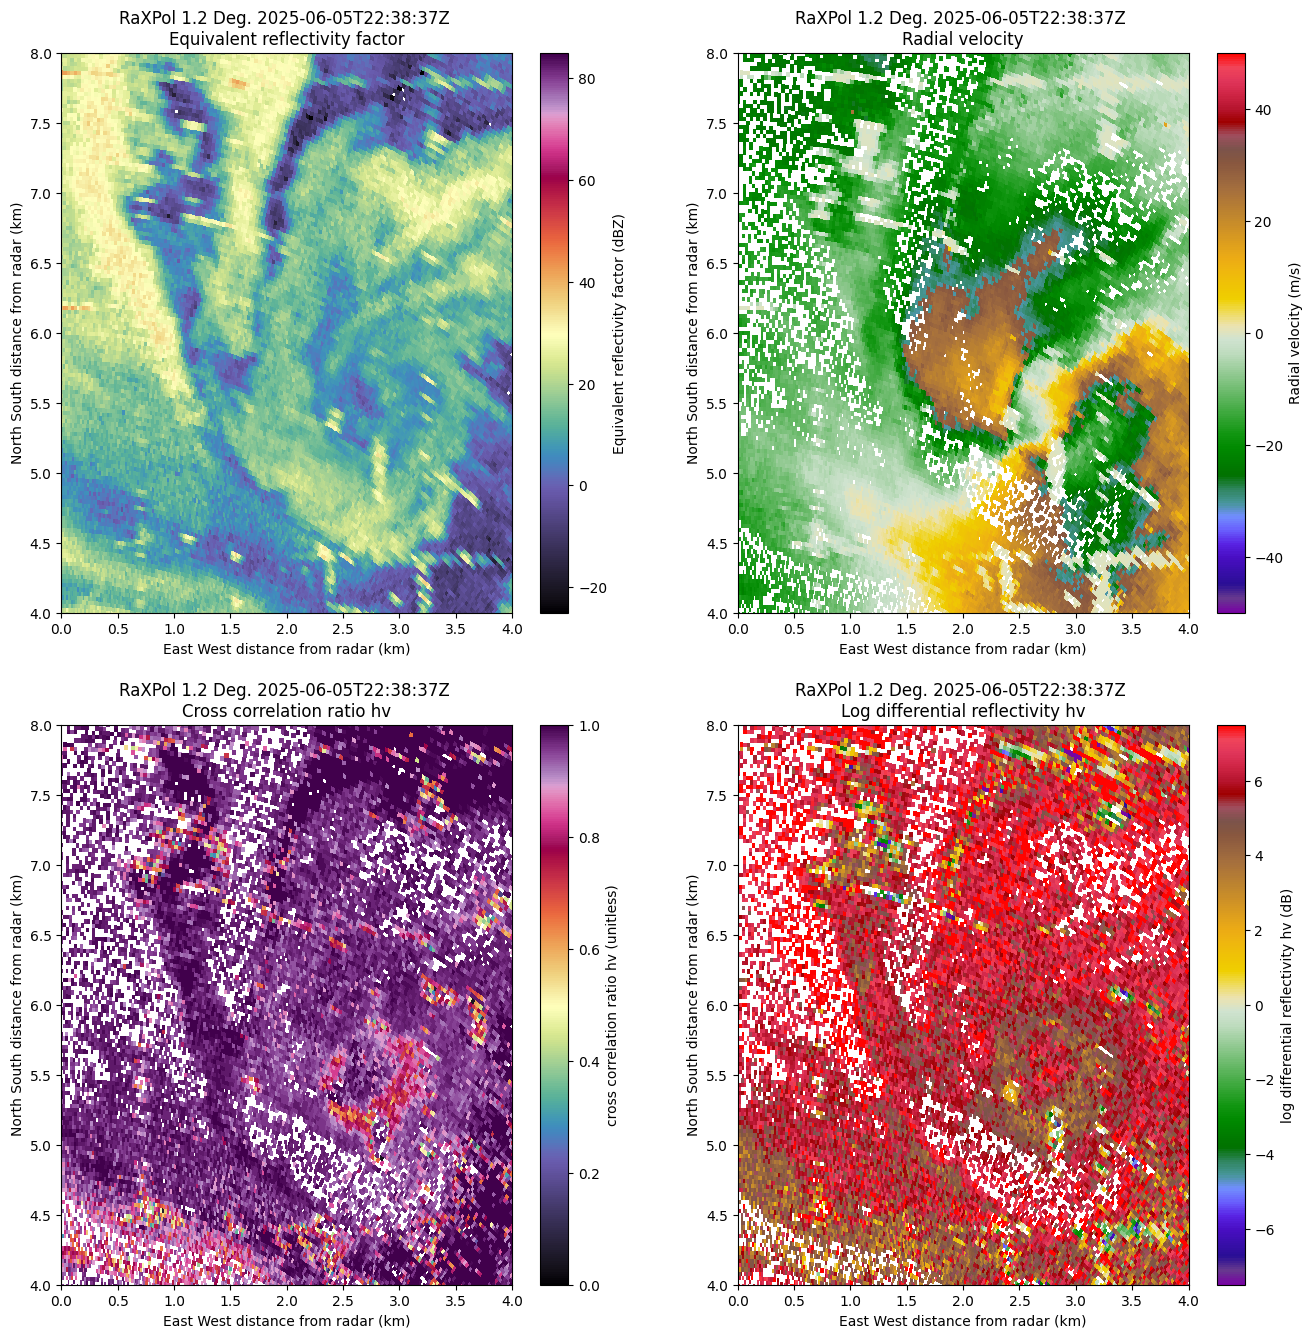

In [117]:
si = 0

xlim = (0, 4)
ylim = (4, 8)

fname_out = '../data/out/20240524/out.nc'

robj = pyart.io.read(fname_out)
fig, axm = plt.subplots(2,2,figsize=(16,16))
disp = pyart.graph.RadarDisplay(robj)

axm = axm.flatten()

ds = -20
where = np.where(robj.fields['SNRH']['data'] < ds) # np.where(robj.fields['DBZ']['data'] < -50)

robj.fields['VEL']['data'][where] = np.nan
robj.fields['RHOHV']['data'][where] = np.nan
robj.fields['ZDR']['data'][where] = np.nan
robj.fields['WIDTH']['data'][where] = np.nan

# robj.add_field('VELD', pyart.correct.dealias_region_based(robj, vel_field='VEL'))
# robj.add_field('VELD', pyart.correct.dealias_unwrap_phase(robj, vel_field='VEL'))

sweep = robj.get_slice(si)

# zz = u.get_heights(robj.range['data'], robj.elevation['data'][sweep])
# xx, yy = u.get_xxyy(robj.azimuth['data'][sweep], robj.range['data'], robj.elevation['data'][sweep])



# heights = np.arange(0, 500, 10)
# con = ax.contour(xx/1e3, yy/1e3, zz, heights, linewidth=0.5, colors='k')
# ax.clabel(con)
# print(robj.elevation['data'][sweep])

# print(robj.fields.keys())
# dict_keys(['DBZ', 'DBZ1', 'ZDR', 'VEL', 'VELV', 'VELH', 'WIDTH', 'PHIDP', 'KDP', 'RHOHV', 'DBMHC', 'DBMVC', 'SNRHC', 'SNRVC', 'NCP', 'BMHGHT', 'DBZC', 'ZDRC'])

ax = axm[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
robj.fields['DBZ']['standard_name'] = 'Equivalent reflectivity factor'
disp.plot_ppi('DBZ', si, cmap='ChaseSpectral', ax=ax, vmin=-25, vmax=85)

ax = axm[1]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
robj.fields['VEL']['standard_name'] = 'Radial velocity'
robj.fields['VEL']['units'] = 'm/s'
disp.plot_ppi('VEL', si, cmap='Carbone42', ax=ax, vmin=-50, vmax=50)

ax = axm[2]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# robj.fields['VELD']['standard_name'] = 'Radial velocity'
# robj.fields['VELD']['units'] = 'm/s'
disp.plot_ppi('RHOHV', si, cmap='ChaseSpectral', ax=ax, vmin=0, vmax=1)

ax = axm[3]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# robj.fields['VELD']['standard_name'] = 'Radial velocity'
# robj.fields['VELD']['units'] = 'm/s'
disp.plot_ppi('ZDR', si, cmap='Carbone42', ax=ax, vmin=-7.5, vmax=7.5)

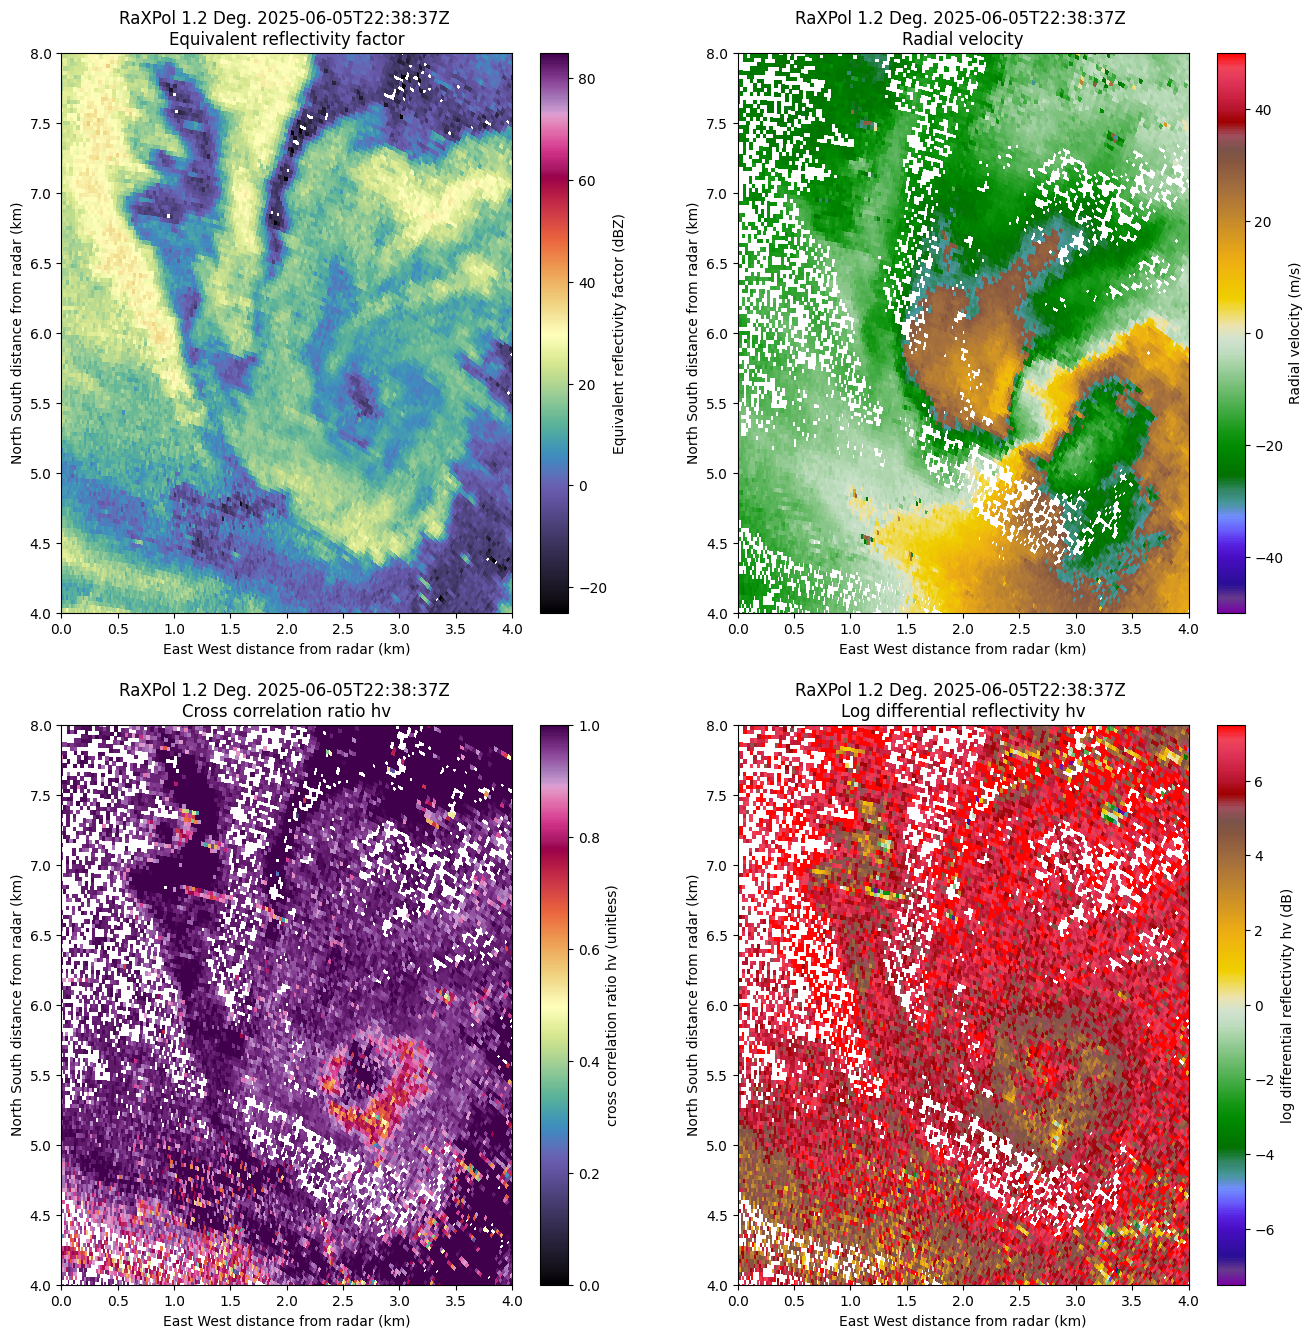

In [115]:
fname_out = '../data/out/20240524/out-f.nc'

si = 0

xlim = (0, 4)
ylim = (4, 8)

robj = pyart.io.read(fname_out)
fig, axm = plt.subplots(2,2,figsize=(16,16))
disp = pyart.graph.RadarDisplay(robj)

axm = axm.flatten()

ds = -20
where = np.where(robj.fields['SNRH']['data'] < ds) # np.where(robj.fields['DBZ']['data'] < -50)

robj.fields['VEL']['data'][where] = np.nan
robj.fields['RHOHV']['data'][where] = np.nan
robj.fields['ZDR']['data'][where] = np.nan
robj.fields['WIDTH']['data'][where] = np.nan

# robj.add_field('VELD', pyart.correct.dealias_region_based(robj, vel_field='VEL'))
# robj.add_field('VELD', pyart.correct.dealias_unwrap_phase(robj, vel_field='VEL'))

sweep = robj.get_slice(si)

# zz = u.get_heights(robj.range['data'], robj.elevation['data'][sweep])
# xx, yy = u.get_xxyy(robj.azimuth['data'][sweep], robj.range['data'], robj.elevation['data'][sweep])



# heights = np.arange(0, 500, 10)
# con = ax.contour(xx/1e3, yy/1e3, zz, heights, linewidth=0.5, colors='k')
# ax.clabel(con)
# print(robj.elevation['data'][sweep])

# print(robj.fields.keys())
# dict_keys(['DBZ', 'DBZ1', 'ZDR', 'VEL', 'VELV', 'VELH', 'WIDTH', 'PHIDP', 'KDP', 'RHOHV', 'DBMHC', 'DBMVC', 'SNRHC', 'SNRVC', 'NCP', 'BMHGHT', 'DBZC', 'ZDRC'])

ax = axm[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
robj.fields['DBZ']['standard_name'] = 'Equivalent reflectivity factor'
disp.plot_ppi('DBZ', si, cmap='ChaseSpectral', ax=ax, vmin=-25, vmax=85)

ax = axm[1]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
robj.fields['VEL']['standard_name'] = 'Radial velocity'
robj.fields['VEL']['units'] = 'm/s'
disp.plot_ppi('VEL', si, cmap='Carbone42', ax=ax, vmin=-50, vmax=50)

ax = axm[2]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# robj.fields['VELD']['standard_name'] = 'Radial velocity'
# robj.fields['VELD']['units'] = 'm/s'
disp.plot_ppi('RHOHV', si, cmap='ChaseSpectral', ax=ax, vmin=0, vmax=1)

ax = axm[3]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# robj.fields['VELD']['standard_name'] = 'Radial velocity'
# robj.fields['VELD']['units'] = 'm/s'
disp.plot_ppi('ZDR', si, cmap='Carbone42', ax=ax, vmin=-7.5, vmax=7.5)